In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
# from keras.utils.data_utils import GeneratorEnqueuer  # We only want this for multithreaded 

from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torch import Tensor
import torch

In [ ]:

train_df = pd.read_csv("/content/gdrive/MyDrive/train.csv")
print("Raw Dataset: ", train_df.shape)
keep = [len(x[:-1].split()) > 0 for x in train_df["question_text"]]
train_df = train_df[keep]
print("After removing empty text:", train_df.shape)
train_df, val_df = train_test_split(train_df, test_size=0.2)
val_df.to_csv("val_df.csv")

Raw Dataset:  (1306122, 3)
After removing empty text: (1306120, 3)


In [ ]:
train_df.head(10)

,qid,question_text,target
1249722,f4e7a7249a278080ac78,What was Jody Rosen's inspiration to write the...,0
1076973,d30c37789d0bb81c8d08,What do waiters feel when they see someone bei...,0
277364,364706e2c86f4f60ddbc,What Is a Decentralization of Currency?,0
367209,47fb19f0aef84108829c,Why do I struggle being myself?,0
265513,33f74d79a2e531415e19,I like LAMP because it seems like the easiest ...,0
30121,05e347a82a63bc5bb181,"What marketing strategies does Frito-Lay, Inc....",0
539181,699fbedc322fbdb753e7,Do you agree that only real men can reject bea...,1
581151,71ddf515d4caadf750fb,How are the job prospects after an MS in CS fr...,0
249890,30e513eeaba9d9fe84dc,Do I have to attempt biology in KCET if I have...,0
1054692,cead3d125f7182dcf87f,"How would you say ""Let's make Rome great again...",0


In [ ]:
# GloVe Embedding
embeddings_index = {}
f = open('/content/gdrive/MyDrive/glove.840B.300d.txt', encoding = 'utf-8')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

In [ ]:
def text_to_array(text):
  
    empyt_emb = np.zeros(300)
    text = text[:-1].split()[:120]
  
    embeds = [embeddings_index.get(x, empyt_emb) for x in text]
    seq_len = len(embeds)
 
    embeds+= [empyt_emb] * (120 - len(embeds))
    return np.array(embeds), seq_len


In [ ]:
# generate validation dataset
embeddings = [text_to_array(X_text) for X_text in tqdm(val_df["question_text"][:])]
val_x, val_xlen = zip(*embeddings)

sorder = np.argsort(val_xlen)[::-1]

val_xlen = np.array(val_xlen)[sorder]
val_x = np.array(val_x)[sorder]
val_y = np.array(val_df["target"][:])[sorder]

In [ ]:
batch_size = 128
def batch_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
            text_arr, text_len = zip(*[text_to_array(text) for text in texts])
            sorder = np.argsort(text_len)[::-1]
            text_arr = np.array(text_arr)[sorder]
            text_len = np.array(text_len)[sorder]
            yield text_arr, text_len, np.array(train_df["target"][i*batch_size:(i+1)*batch_size])[sorder]

In [ ]:
class BiLSTM_model(nn.Module):
    def __init__(self, embedding_size=300, hidden_size=128, n_layers = 1):
        super(BiLSTM_model, self).__init__()
        self.lstm = nn.LSTM(300, hidden_size, 
                            batch_first=True, num_layers=n_layers,
                            bidirectional=True)
        
        self.fc = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, input_lengths):
        x = pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)
        x, (h1, h2) = self.lstm(x)
        out = torch.cat((h1[0], h1[-1]), 1) # TODO check if :2 really is FW and BW of last layer!
        out = self.fc(out)
        return self.sigmoid(out).flatten()
        # return memory

In [ ]:
from keras.utils.data_utils import GeneratorEnqueuer

In [ ]:
def val_gen(batch_size=256):
    n_batches = math.ceil(len(val_x) / batch_size)
    for idx in range(n_batches):
        xb = val_x[idx *batch_size:(idx+1) * batch_size]
        xlb = val_xlen[idx *batch_size:(idx+1) * batch_size]
        yb = val_y[idx *batch_size:(idx+1) * batch_size]
        yield xb, xlb, yb

In [ ]:
losses = []
losses_ =[]
train_vals = []
train_vals_ = []
vals = []
epochs = 1
lr_ = 0.0001
model = BiLSTM_model()
minibatch = 64
useminibatch = True
hidden = 64
n_layers = 2
# model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_model(hidden_size = hidden, n_layers = n_layers)

model.to(device)

bcloss = nn.BCELoss()

my_generator = GeneratorEnqueuer(batch_gen(train_df))
my_generator.start()
mg =  my_generator.get()

model.train()

optimizer = optim.Adam(model.parameters(), lr = lr_)
for epoch in range(epochs):
    indices = np.arange(batch_size)
    if useminibatch:
      perm = torch.randperm(batch_size)
      indices = perm[:minibatch]
    print("epoch: ", epoch + 1)
    for i, (x, xlen, y) in tqdm(enumerate(mg)):
  
        optimizer.zero_grad()
        try:
          x = Tensor(x[indices])
          y_pred = model(Variable(Tensor(x)).to(device), xlen[indices])
          loss = bcloss(y_pred, Tensor(y[indices]).to(device))
          
          loss.backward()
          losses.append(loss.data.cpu().numpy())
          optimizer.step()
        except:
          pass
    
        if (i + 1) % 1000 == 0:
            print("Iter: {}".format(i+1))
            print("\tAverage training loss: {:.5f}".format(np.mean(losses)))
            
            losses_.append(np.mean(losses))
            
            losses = []
            
            model.eval()
            all_preds = []
            ys = []
            for x, xlen, y in val_gen():
                y_pred = model(Variable(Tensor(x)).to(device), xlen)
                all_preds.extend(y_pred.cpu().data.numpy())
          
            score = f1_score(val_y, np.array(all_preds).flatten() > 0.5)
            
            vals.append(score)
            print("\tVal F1 score: {:.5f}".format(score))
            model.train()
        if (i + 1) % 12000 == 0:  # We are done
            break

epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Iter: 1000
	Average training loss: 0.14480
	Val F1 score: 0.52964
Iter: 2000
	Average training loss: 0.12086
	Val F1 score: 0.52473
Iter: 3000
	Average training loss: 0.11777
	Val F1 score: 0.49448
Iter: 4000
	Average training loss: 0.11760
	Val F1 score: 0.60788
Iter: 5000
	Average training loss: 0.11316
	Val F1 score: 0.59150
Iter: 6000
	Average training loss: 0.11189
	Val F1 score: 0.60000
Iter: 7000
	Average training loss: 0.10974
	Val F1 score: 0.54274
Iter: 8000
	Average training loss: 0.11087
	Val F1 score: 0.58736
Iter: 9000
	Average training loss: 0.10741
	Val F1 score: 0.61080
Iter: 10000
	Average training loss: 0.10456
	Val F1 score: 0.63269
Iter: 11000
	Average training loss: 0.10381
	Val F1 score: 0.63178
Iter: 12000
	Average training loss: 0.10362
	Val F1 score: 0.64376


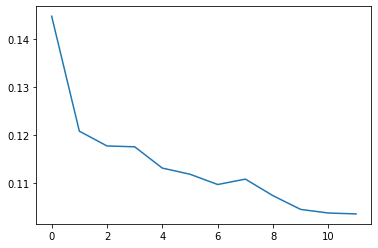

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(losses_)

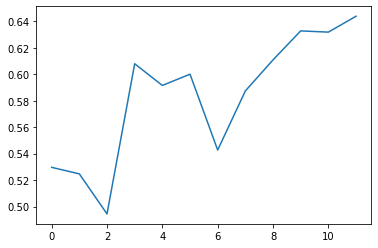

In [ ]:
plt.plot(vals)

In [ ]:
model.eval()
all_preds = []
for x, xlen, y in val_gen():
  y_pred = model(Variable(Tensor(x)), xlen)
  all_preds.extend(y_pred.cpu().data.numpy())
          
print(f1_score(val_y, np.array(all_preds).flatten() > 0.5))
print(precision_score(val_y, np.array(all_preds).flatten() > 0.5))
print(recall_score(val_y, np.array(all_preds).flatten() > 0.5))

0.64376130198915
0.6793893129770993
0.6116838487972509
